In [90]:

# Download Data from Yahoo Finance
import datetime as dt
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
# Pour lire les données de Yahoo Finance, vous devez installer le toolbox yfinance
import yfinance as yf 

def get_dow():
    start_sp = dt.datetime(2004,12,31)
    end_sp = dt.datetime(2019, 12,31)

    # Dow Jones index
    # 1st Dow Jones Index + 30 components
    dow30 = ['^DJI','AXP', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'DD', 'XOM',
            'GE', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM',
            'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG',
            'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WMT', 'DIS']

    dow_data = yf.download(dow30, start=start_sp, end=end_sp,group_by="ticker")

    return dow_data.transpose()

dow_prices = get_dow()


[*********************100%***********************]  31 of 31 completed


In [98]:
#TODO: ne pas ignorer tout les erreurs
def calculate_fivedays_roi(stock_price, date):
    roi = None
    try:
        past_date = date - np.timedelta64(5, "D")
        current_value = stock_price.loc[date]
        try:
            past_value = stock_price.loc[past_date]
        except:
            try:
                past_value = stock_price.loc[past_date - np.timedelta64(1, "D")]
            except:
                past_value = stock_price.loc[past_date + np.timedelta64(1, "D")]
        
        roi = (current_value - past_value)/past_value * 100        
    except KeyError:
        pass        
    return roi

# Calculate roi over a period of time
def get_rois(stock_prices, ticker, start_date, end_date):
    rois = []
    dates = []
    company_stock_price = stock_prices.loc[(ticker, "Close")]

    # calculate de ROI over the last 250 days
    curr_date = start_date
    while(curr_date < end_date):
        roi = calculate_fivedays_roi(company_stock_price, curr_date)
        if roi:
            rois.append(roi)
            dates.append(curr_date)
        curr_date = curr_date + np.timedelta64(1, "D")                

    return pd.Series(rois,index=dates)

# Calculate roi for a bunch of campanies
def get_companies_rois(stock_prices, start_date, end_date):
    tickers = stock_prices.index.get_level_values(0).unique().array
            
    result = pd.DataFrame()
    for ticker in tickers:             
        result[ticker] = get_rois(stock_prices, ticker, start_date, end_date)
    
    return result
    
def calculate_mean_roi(rois):
    rois["Mean"] = rois.mean(axis=1)
    return rois

In [99]:
def historic_var_comparison(rois):
    five_percent = int(250 * 0.05)
    return rois.nsmallest(five_percent)[five_percent-1]

def parametric_var_comparison(rois):
    mu = np.mean(rois)
    std = np.std(rois)
    return mu - 1.96 * std

def modified_var_comparison(rois):
    mu = np.mean(rois)
    std = np.std(rois)
    skew = stats.skew(rois)
    kurtosis = stats.kurtosis(rois)
    ZCF = mu + (skew/6)*(mu**2 - 1) + (kurtosis/24) * (mu**3 - 3*mu) + (skew**2/36) * (2* mu**3 - 5*mu)
    return mu - ZCF * std

def calculate_var(stock_prices, comparison_func):
    period = 250    
    # [min date + 5, higher date] (we need 5 days buffer to calculate roi)
    start_date = dow_prices.columns.array.min() + np.timedelta64( 5, "D")
    end_date = dow_prices.columns.array.max()
    rois = get_companies_rois(stock_prices, start_date, end_date)
    rois = calculate_mean_roi(rois)
    
    var_array = []
    dates = []
    curr_date = start_date + np.timedelta64( 250, "D")
    while(curr_date < end_date):
        period_end = curr_date
        period_begin = period_end - np.timedelta64(period, "D")
        
        var = comparison_func(rois.loc[period_begin:period_end]["Mean"])
        var_array.append(var)
        dates.append(curr_date)
        
        curr_date = curr_date + np.timedelta64(1, "D")
    return pd.Series(var_array, index=dates).apply(lambda x : abs(x))

def plot_var(var_values, var_type):
    plt.plot(var_values.index, var_values )
    plt.ylabel('VaR')
    plt.xlabel('Time')
    plt.title('{0} VaR over time'.format(var_type))
    plt.show()

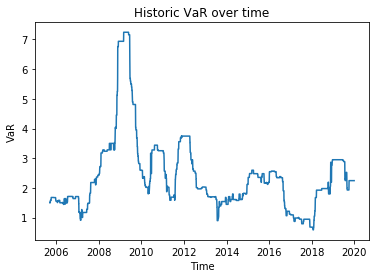

In [100]:
var_array = calculate_var(dow_prices, historic_var_comparison)
plot_var(var_array, "Historic")

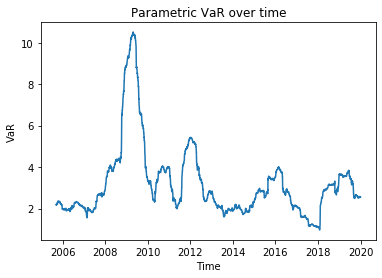

In [101]:
var_array = calculate_var(dow_prices, parametric_var_comparison)
plot_var(var_array, "Parametric")

In [102]:
def increment_dates(dates, period):
    result = []
    for date in dates:
        result.append(date + np.timedelta64( period, "D"))
    return result

def calculate_RiskMetrics_var(stock_prices):
    period = 250    
    # [min date + 5, higher date] (we need 5 days buffer to calculate roi)
    start_date = dow_prices.columns.array.min() + np.timedelta64( 5, "D")
    end_date = dow_prices.columns.array.max()
    rois = get_companies_rois(stock_prices, start_date, end_date)
    rois = calculate_mean_roi(rois)
    
    var_array = []
    dates = []
    alpha = 0.96
    period_begin = start_date
    period_end = period_begin + np.timedelta64( period, "D")
    previous_std = np.std(rois.loc[period_begin:period_end]["Mean"])
    period_begin, period_end = increment_dates([period_begin, period_end], period)
        
    while(period_begin < end_date):
        std = np.std(rois.loc[period_begin:period_end]["Mean"])
        std = math.sqrt(alpha*math.pow(std,2)+(1-alpha)*math.pow(previous_std,2))
        var = -1.96*std
        var_array.append(var)
        dates.append(period_begin)
        
        period_begin, period_end = increment_dates([period_begin, period_end], period)
        previous_std = std
        
    return pd.Series(var_array, index=dates).apply(lambda x : abs(x))
    

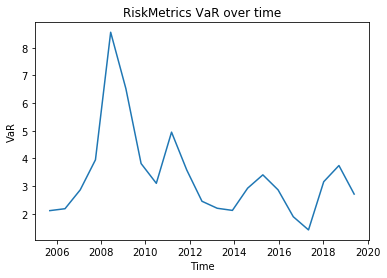

In [103]:
var_array = calculate_RiskMetrics_var(dow_prices)
plot_var(var_array,"RiskMetrics")

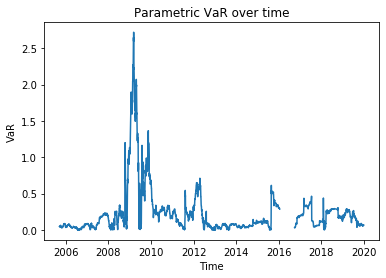

In [104]:
var_array = calculate_var(dow_prices, modified_var_comparison)
plot_var(var_array, "Parametric")